In [ ]:
!pip install datasets transformers[sentencepiece] sacrebleu
!pip install numpy==1.24.3

In [ ]:
!pip install datasets
!pip install transformers[torch]

In [3]:
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM
import matplotlib.pyplot as plt
import pandas as pd
import sys

### Visualization

In [22]:
def words_diff(s1, s2):
    count = {}
    for word in s1.split():
        count[word] = count.get(word, 0) + 1

    for word in s2.split():
        count[word] = count.get(word, 0) + 1

    return [word for word in count if count[word] == 1]

def translate(model, inference_request, tokenizer):
    input_ids = tokenizer(inference_request, return_tensors="pt").input_ids
    outputs = model.generate(input_ids=input_ids)
    return tokenizer.decode(outputs[0],
          skip_special_tokens=True, temperature=0)

In [18]:
dir_path = 'data/interim/'

test_df = pd.read_csv(dir_path + 'test.csv', index_col=0)
test_df.reset_index(drop=True, inplace=True)

In [5]:
model_checkpoint = "t5-small"

# we will use autotokenizer for this purpose
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# prefix for model input
prefix = "make sentence neutral:"

# loading the model and run inference for it

model = AutoModelForSeq2SeqLM.from_pretrained(
     'models/checkpoint-10000')
# model = AutoModelForSeq2SeqLM.from_pretrained(sys.path[1] + 'models/best.pt')
model.eval()
model.config.use_cache = False

Take 1000 random samples from test data and translate them

In [23]:
N = 1000
sent = test_df.sample(n=N).source.values.tolist()
trn = []
for s in sent:
    inference_request = prefix + s
    t = translate(model, inference_request, tokenizer)
    trn.append(t)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [24]:
word_count = {}
vocab = []
for i in range(N):
    words = words_diff(sent[i], trn[i])
    for wrd in words:
        if len(wrd) > 3:
            if wrd in vocab:
                word_count[wrd] = word_count[wrd] + 1
            else:
                word_count[wrd] = 1
                vocab.append(wrd)

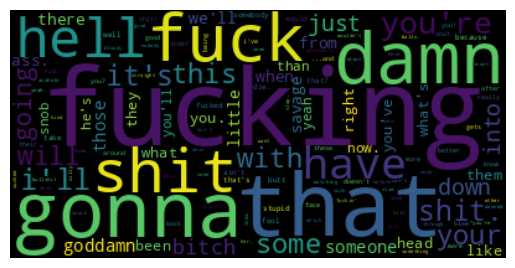

In [29]:
from wordcloud import WordCloud, STOPWORDS

# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords).generate_from_frequencies(word_count)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### Evaluate

In [30]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

clf_name = 'SkolkovoInstitute/roberta_toxicity_classifier_v1'
clf = RobertaForSequenceClassification.from_pretrained(clf_name)
clf_tokenizer = RobertaTokenizer.from_pretrained(clf_name)

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier_v1 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
import torch

def predict_toxicity(texts):
    with torch.inference_mode():
        inputs = clf_tokenizer(texts, return_tensors='pt', padding=True)
        out = torch.softmax(clf(**inputs).logits, -1)[:, 1].cpu().numpy()
    return out

Evaluation for original data

In [38]:
import numpy as np

sent_tox_scores = np.zeros(N)

for s in sent:
    tox = predict_toxicity(s)
    sent_tox_scores[i] = tox

print(sent_tox_scores.mean())
print(sent_tox_scores.max())
print(sent_tox_scores.min())

0.000999032735824585
0.999032735824585
0.0


Evaluation for translations

In [36]:
trn_tox_scores = np.zeros(N)

for t in trn:
    tox = predict_toxicity(t)
    trn_tox_scores[i] = tox

print(trn_tox_scores.mean())
print(trn_tox_scores.max())
print(trn_tox_scores.min())

6.082661639084108e-08
6.082661639084108e-05
0.0
